## RANDOM FOREST ON MNIST

In this notebook we will perform classification analysis of MNIST digits
using random forest estimator. We will:

<ul>
<li>Implement load_mnist_digits() function to load MNIST digits dataset</li>
<li>Impplement flattent_and_normalize() function to preprocess images for classification</li>
<li>Train random forest model and apply it to test images</li>
<li>Implement F1 score to measure classification performance</li>
<li>Visualize importance of individual pixels for classification</li>
<li>Implement misclassified_digits() function to visualize misclassified examples by label</li>
<li>Report confusion matrix to evaluate most frequent error types</li>
</ul>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import mnist

%matplotlib inline
np.random.seed(1)

Load and normalize MNIST data.

In [2]:
# Load mnist digits

def load_mnist_digits():
    """
    Loads and returns MNIST digits dataset
    
    Returns:
    X_train - training image examples, of shape (60000, 78, 78)
    Y_train - training image labels, of shape (60000, )
    m_train - number of training image examples, of type "integer"
    
    X_test - test image examples, of shape (10000, 78, 78)
    Y_test - test image labels, of shape (10000, )
    m_test - number of test image examples, of type "integer"
    """
    
    X_train = mnist.train_images()
    Y_train = mnist.train_labels()
    
    X_test = mnist.test_images()
    Y_test = mnist.test_labels()

    m_train = X_train.shape[0]
    m_test = X_test.shape[0]
    
    return X_train, Y_train, m_train, X_test, Y_test, m_test

X_train, Y_train, m_train, X_test, Y_test, m_test = load_mnist_digits()

In [3]:
def flatten_and_normalize(X):
    """
    Flattens and normalizes pixel values of input matrix X.
    
    Arguments:
    X - matrix of image examples, of shape (m, 28, 28), of type "float"
    
    Returns:
    X - a matrix of flattened and normalized digit examples, of shape (m, 784) and type "float"
    """
    
    nsamples, nx, ny = X.shape
    X = np.reshape(X, (nsamples, nx*ny)) / 255
    
    return X

X_train = flatten_and_normalize(X_train)
X_test = flatten_and_normalize(X_test)

We fit a basic random forest model with 200 trees.

In [4]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=0, n_jobs=4)
rf_model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=4,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

We evaluate the model using average F1 score of predictions:

In [5]:
def F1_score(Y_hat, Y):
    """
    Calculates average F1 score across classes
    
    Arguments:
    Y_hat -- vector of predicted labels, of shape (m, )
    Y  -- vector of true labels, of shape (m, )
    
    Returns:
    res -- real number, average F1 score
    """
    
    m = Y_hat.shape[0]
    
    ## Calculate per class accuracy
    scores = []
    unique_labels = np.unique(Y)
    for label in unique_labels:
        positives = np.sum(Y == label)
        true_positives = np.dot( (Y_hat == label).astype(int), (Y == label).astype(int))
        false_positives = np.dot( (Y_hat == label).astype(int), (Y != label).astype(int))
        
        negatives = np.sum(Y != label)
        true_negatives = np.dot( (Y_hat != label).astype(int), (Y != label).astype(int))
        false_negatives = np.dot( (Y_hat != label).astype(int), (Y == label).astype(int))

        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        F1_score = round(2 * precision * recall / (precision + recall), 5)
        
        scores.append(F1_score)
        
    res = round(np.mean(np.array(scores)), 2)
    return res
    
Y_hat_test = rf_model.predict(X_test)
F1 = F1_score(Y_hat_test, Y_test)
print("F1-score: " + str(F1))

F1-score: 0.97


Plot pixel importances

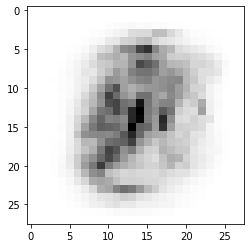

In [6]:
pixel_importance = rf_model.feature_importances_
min_value = np.amin(pixel_importance)
max_value = np.amax(pixel_importance)

pixel_importance = 255 * (pixel_importance - min_value) / (max_value - min_value)
pixel_importance = np.reshape(pixel_importance, (28, 28))
pixel_importance = 255 - pixel_importance

plt.imshow(pixel_importance, cmap='gray')
plt.show()

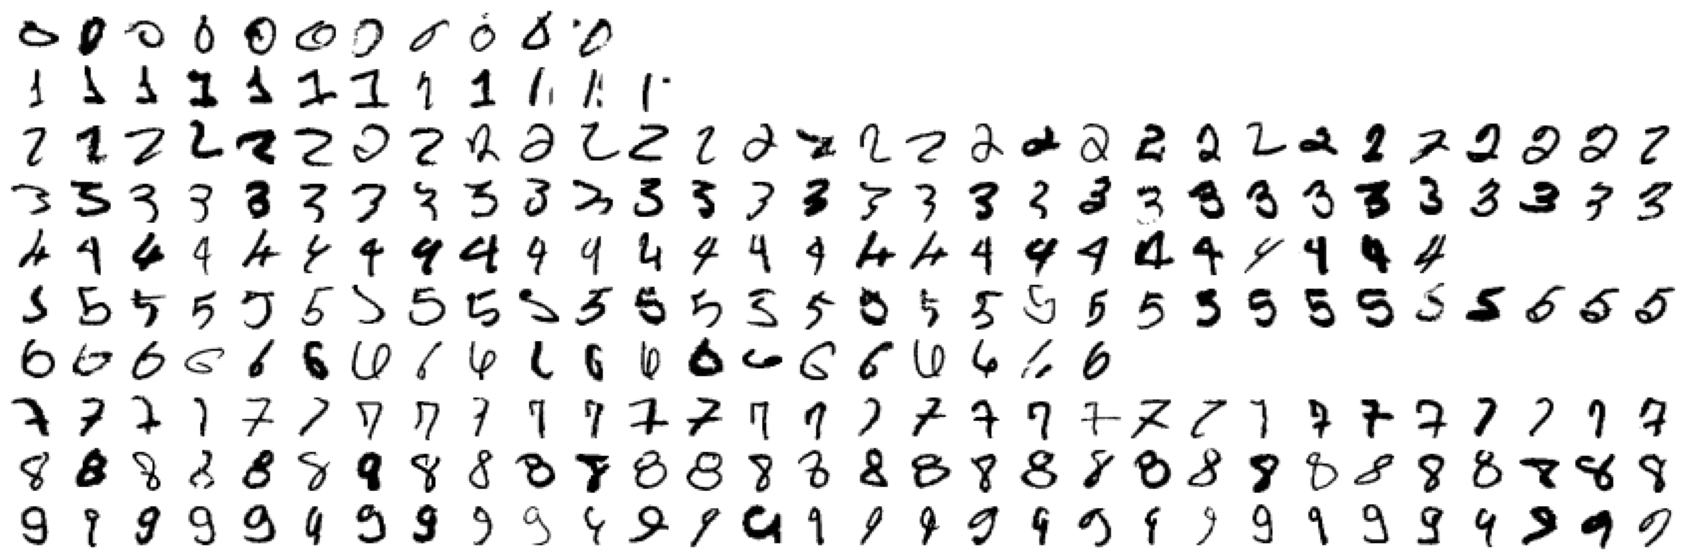

In [7]:
def plot_misclassified_digits(X, Y, Y_hat, max_examples=30):
    """
    Plots misclassified examples of digits
    
    Arguments:
    X -- matrix containing examples, of shape(m, 784)
    Y -- matrix of labels, of shape (m, )
    Y_hat -- matrix of predicted labels, of shape (m, )
    max_examples -- number of examples to show per label
    """
    
    misclassified = X[np.logical_not(np.equal(Y_hat, Y)), :]

    errors_by_label = np.zeros((10, max_examples, 28, 28))
    plot_examples = np.zeros((10*28, max_examples*28))
    for i in range(10):
        error_examples = X_test[np.multiply(Y == i, Y_hat != i), :]
        error_examples = np.reshape(error_examples, (error_examples.shape[0], 28, 28))

        for j in range(max_examples):
            if(j < error_examples.shape[0]):
                plot_examples[i*28:(i+1)*28, j*28:(j+1)*28] = error_examples[j, :, :]
            
    plot_examples = 1-plot_examples

    fig, ax = plt.subplots(figsize=(max_examples, 10))
    plt.imshow(plot_examples, cmap='gray', aspect='auto')
    plt.axis('off')
    plt.show()
    
    return
    
plot_misclassified_digits(X_test, Y_test, Y_hat_test)

Let's also evaluate confusion matrix of predictions.

In [8]:
confusion_matrix(Y_test, Y_hat_test)

array([[ 969,    0,    1,    0,    0,    2,    4,    1,    3,    0],
       [   0, 1123,    3,    3,    0,    2,    2,    1,    1,    0],
       [   5,    0, 1000,    6,    4,    0,    3,    9,    5,    0],
       [   0,    0,    9,  979,    0,    4,    0,    8,    7,    3],
       [   1,    0,    1,    0,  956,    0,    6,    0,    2,   16],
       [   3,    0,    0,   10,    4,  860,    7,    1,    4,    3],
       [   7,    3,    0,    0,    3,    4,  938,    0,    3,    0],
       [   1,    3,   19,    0,    0,    0,    0,  989,    5,   11],
       [   4,    0,    4,    8,    3,    8,    3,    4,  932,    8],
       [   7,    5,    1,   10,    9,    3,    1,    4,    3,  966]])

As we can see, the majority of misclassified examples are as follows:
<ul>
<li>19 cases of 7 misclassified as 2</li>
<li>16 cases of 4 misclassified as 9</li>
<li>11 cases of 7 misclassified as 9</li>
<li>10 cases of 9 misclassified as 3</li>
</ul>
